In [1]:
import re 
import tinycss2
import argparse
import textwrap
import sys
import os
from enum import Enum
import json
from webencodings import ascii_lower

import subprocess
import shlex
from termcolor import colored

from IPython.display import Image, display
from graphviz import Source

https://ruslanspivak.com/lsbasi-part1/
https://github.com/aagm/tinycss2/blob/master/tinycss2/parser.py

In [3]:
class bcolors:
    """
    for shell prompt
    """
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

class css2vl:
    """
    Dicts needed to translate language
    """
    type_dict={
        'polygon': 'fill',
        'line': 'line',
        'point': 'symbol',
        'marker': 'circle',
        'text': 'symbol'

    }

    cond_dict = {
        '>=': '>=',
        '<=': '<=',
        '=': '==',
        '==': '==',
        '>': '>',
        '<': '<',
        '!=':'!='
    }
    estStyleMatch = {
        'fill':{
            'polygon-fill': 'fill-color',
            'polygon-opacity': 'fill-opacity',
            'polygon-pattern-file':{
                "root":"sprite",
                "layer":"fill-pattern"
            }
        },
        'line':{
            'line-color': 'line-color',
            'line-width': 'line-width',
            'line-opacity': 'line-opacity',
            'line-dasharray': 'line-dasharray',
            'line-cap': 'line-cap',
            'line-miterlimit': 'line-miter-limit',
            'line-join': 'line-join',
            'line-offset': 'line-offset',
            'line-pattern-file':{
                "root":"sprite",
                "layer":"line-pattern"       
            }    
        },
        'symbol':{
            'marker-width': 'icon-size',
            'marker-fill': 'icon-color',
            'marker-fill-opacity': 'icon-opacity',
            'marker-line-color': 'icon-halo-color',
            'marker-line-width': 'icon-halo-width',
            'marker-line-opacity': 'icon-halo-color',
            'marker-allow-overlap':'icon-allow-overlap',
            'marker-ignore-placement':'icon-ignore-placement',
            'marker-file':{
                "root":"sprite",
                "layer":'icon-image'
            },
            'marker-spacing':'icon-padding',
            'text-allow-overlap':'text-allow-overlap',
            'text-align':'text-justify',
            'text-fill':'text-color',
            'text-name':'text-field',
            'text-face-name':'text-font',
            'text-halo-fill':'text-halo-color',
            'text-halo-radius':'text-halo-width',
            'text-character-spacing':'text-letter-spacing',
            'text-line-spacing':'text-line-height',
            'text-wrap-width':'text-max-width',
            'text-dx':'text-offset',
            'text-dy':'text-offset',
            'text-opacity':'text-opacity',
            'text-min-distance':'text-padding',
            'text-size':'text-size'
        },
        'circle':{
            'marker-width': 'circle-radius',
            'marker-fill': 'circle-color',
            'marker-fill-opacity': 'circle-opacity',
            'marker-line-color': 'circle-stroke-color',
            'marker-line-width': 'circle-stroke-width',
            'marker-line-opacity': 'circle-stroke-opacity',      
        }    
    }

In [ ]:
###############################################################################
#                                                                             #
#  Parser - tokenizer - Lexer                                                 #
#                                                                             #
###############################################################################

_NUMBER_RE = re.compile(r'[-+]?([0-9]*\.)?[0-9]+([eE][+-]?[0-9]+)?')
_HEX_ESCAPE_RE = re.compile(r'([0-9A-Fa-f]{1,6})[ \n\t]?')


def parse_component_value_list(css, skip_comments=False):
    """Parse a list of component values.
    :param css: A :term:`string`.
    :param skip_comments:
        Ignore CSS comments.
        The return values (and recursively its blocks and functions)
        will not contain any :class:`~tinycss2.ast.Comment` object.
    :returns: A list of :term:`component values`.
    """
    css = (css.replace('\0', '\uFFFD')
           # This turns out to be faster than a regexp:
           .replace('\r\n', '\n').replace('\r', '\n').replace('\f', '\n'))
    length = len(css)
    token_start_pos = pos = 0  # Character index in the css source.
    line = 1  # First line is line 1.
    last_newline = -1
    root = tokens = []
    end_char = None  # Pop the stack when encountering this character.
    stack = []  # Stack of nested blocks: (tokens, end_char) tuples.

    while pos < length:
        newline = css.rfind('\n', token_start_pos, pos)
        if newline != -1:
            line += 1 + css.count('\n', token_start_pos, newline)
            last_newline = newline
        # First character in a line is in column 1.
        column = pos - last_newline
        token_start_pos = pos
        c = css[pos]

        if c in ' \n\t':
            pos += 1
            while css.startswith((' ', '\n', '\t'), pos):
                pos += 1
            value = css[token_start_pos:pos]
            tokens.append(WhitespaceToken(line, column, value))
            continue
        elif (c in 'Uu' and pos + 2 < length and css[pos + 1] == '+' and
              css[pos + 2] in '0123456789abcdefABCDEF?'):
            start, end, pos = _consume_unicode_range(css, pos + 2)
            tokens.append(UnicodeRangeToken(line, column, start, end))
            continue
        elif css.startswith('-->', pos):  # Check before identifiers
            tokens.append(LiteralToken(line, column, '-->'))
            pos += 3
            continue
        elif _is_ident_start(css, pos):
            value, pos = _consume_ident(css, pos)
            if not css.startswith('(', pos):  # Not a function
                tokens.append(IdentToken(line, column, value))
                continue
            pos += 1  # Skip the '('
            if ascii_lower(value) == 'url':
                value, pos, error = _consume_url(css, pos)
                if value is not None:
                    repr = 'url("{}")'.format(serialize_string_value(value))
                    if error is not None:
                        error_key = error[0]
                        if error_key == 'eof-in-string':
                            repr = repr[:-2]
                        elif error_key == 'eof-in-url':
                            repr = repr[:-1]
                    tokens.append(URLToken(line, column, value, repr))
                if error is not None:
                    tokens.append(ParseError(line, column, *error))
                continue
            arguments = []
            tokens.append(FunctionBlock(line, column, value, arguments))
            stack.append((tokens, end_char))
            end_char = ')'
            tokens = arguments
            continue

        match = _NUMBER_RE.match(css, pos)
        if match:
            pos = match.end()
            repr_ = css[token_start_pos:pos]
            value = float(repr_)
            int_value = int(repr_) if not any(match.groups()) else None
            if pos < length and _is_ident_start(css, pos):
                unit, pos = _consume_ident(css, pos)
                tokens.append(DimensionToken(
                    line, column, value, int_value, repr_, unit))
            elif css.startswith('%', pos):
                pos += 1
                tokens.append(PercentageToken(
                    line, column, value, int_value, repr_))
            else:
                tokens.append(NumberToken(
                    line, column, value, int_value, repr_))
        elif c == '@':
            pos += 1
            if pos < length and _is_ident_start(css, pos):
                value, pos = _consume_ident(css, pos)
                tokens.append(AtKeywordToken(line, column, value))
            else:
                tokens.append(LiteralToken(line, column, '@'))
        elif c == '#':
            pos += 1
            if pos < length and (
                    css[pos] in '0123456789abcdefghijklmnopqrstuvwxyz'
                                '-_ABCDEFGHIJKLMNOPQRSTUVWXYZ' or
                    ord(css[pos]) > 0x7F or  # Non-ASCII
                    # Valid escape:
                    (css[pos] == '\\' and not css.startswith('\\\n', pos))):
                is_identifier = _is_ident_start(css, pos)
                value, pos = _consume_ident(css, pos)
                tokens.append(HashToken(line, column, value, is_identifier))
            else:
                tokens.append(LiteralToken(line, column, '#'))
        elif c == '{':
            content = []
            tokens.append(CurlyBracketsBlock(line, column, content))
            stack.append((tokens, end_char))
            end_char = '}'
            tokens = content
            pos += 1
        elif c == '[':
            content = []
            tokens.append(SquareBracketsBlock(line, column, content))
            stack.append((tokens, end_char))
            end_char = ']'
            tokens = content
            pos += 1
        elif c == '(':
            content = []
            tokens.append(ParenthesesBlock(line, column, content))
            stack.append((tokens, end_char))
            end_char = ')'
            tokens = content
            pos += 1
        elif c == end_char:  # Matching }, ] or )
            # The top-level end_char is None (never equal to a character),
            # so we never get here if the stack is empty.
            tokens, end_char = stack.pop()
            pos += 1
        elif c in '}])':
            tokens.append(ParseError(line, column, c, 'Unmatched ' + c))
            pos += 1
        elif c in ('"', "'"):
            value, pos, error = _consume_quoted_string(css, pos)
            if value is not None:
                repr = '"{}"'.format(serialize_string_value(value))
                if error is not None:
                    repr = repr[:-1]
                tokens.append(StringToken(line, column, value, repr))
            if error is not None:
                tokens.append(ParseError(line, column, *error))
        elif css.startswith('/*', pos):  # Comment
            pos = css.find('*/', pos + 2)
            if pos == -1:
                if not skip_comments:
                    tokens.append(
                        Comment(line, column, css[token_start_pos + 2:]))
                break
            if not skip_comments:
                tokens.append(
                    Comment(line, column, css[token_start_pos + 2:pos]))
            pos += 2
        elif css.startswith('<!--', pos):
            tokens.append(LiteralToken(line, column, '<!--'))
            pos += 4
        elif css.startswith('||', pos):
            tokens.append(LiteralToken(line, column, '||'))
            pos += 2
        elif c in '~|^$*':
            pos += 1
            if css.startswith('=', pos):
                pos += 1
                tokens.append(LiteralToken(line, column, c + '='))
            else:
                tokens.append(LiteralToken(line, column, c))
        else:
            tokens.append(LiteralToken(line, column, c))
            pos += 1
    return root


def _is_name_start(css, pos):
    """Return true if the given character is a name-start code point."""
    # https://www.w3.org/TR/css-syntax-3/#name-start-code-point
    c = css[pos]
    return (
        c in 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_' or
        ord(c) > 0x7F)


def _is_ident_start(css, pos):
    """Return True if the given position is the start of a CSS identifier."""
    # https://drafts.csswg.org/css-syntax/#would-start-an-identifier
    if _is_name_start(css, pos):
        return True
    elif css[pos] == '-':
        pos += 1
        return (
            # Name-start code point or hyphen:
            (pos < len(css) and (
                _is_name_start(css, pos) or css[pos] == '-')) or
            # Valid escape:
            (css.startswith('\\', pos) and not css.startswith('\\\n', pos)))
    elif css[pos] == '\\':
        return not css.startswith('\\\n', pos)
    return False


def _consume_ident(css, pos):
    """Return (unescaped_value, new_pos).
    Assumes pos starts at a valid identifier. See :func:`_is_ident_start`.
    """
    # http://dev.w3.org/csswg/css-syntax/#consume-a-name
    chunks = []
    length = len(css)
    start_pos = pos
    while pos < length:
        c = css[pos]
        if c in ('abcdefghijklmnopqrstuvwxyz-_0123456789'
                 'ABCDEFGHIJKLMNOPQRSTUVWXYZ') or ord(c) > 0x7F:
            pos += 1
        elif c == '\\' and not css.startswith('\\\n', pos):
            # Valid escape
            chunks.append(css[start_pos:pos])
            c, pos = _consume_escape(css, pos + 1)
            chunks.append(c)
            start_pos = pos
        else:
            break
    chunks.append(css[start_pos:pos])
    return ''.join(chunks), pos


def _consume_quoted_string(css, pos):
    """Return (unescaped_value, new_pos)."""
    # http://dev.w3.org/csswg/css-syntax/#consume-a-string-token
    error = None
    quote = css[pos]
    assert quote in ('"', "'")
    pos += 1
    chunks = []
    length = len(css)
    start_pos = pos
    while pos < length:
        c = css[pos]
        if c == quote:
            chunks.append(css[start_pos:pos])
            pos += 1
            break
        elif c == '\\':
            chunks.append(css[start_pos:pos])
            pos += 1
            if pos < length:
                if css[pos] == '\n':  # Ignore escaped newlines
                    pos += 1
                else:
                    c, pos = _consume_escape(css, pos)
                    chunks.append(c)
            # else: Escaped EOF, do nothing
            start_pos = pos
        elif c == '\n':  # Unescaped newline
            return None, pos, ('bad-string', 'Bad string token')
        else:
            pos += 1
    else:
        error = ('eof-in-string', 'EOF in string')
        chunks.append(css[start_pos:pos])
    return ''.join(chunks), pos, error


def _consume_escape(css, pos):
    r"""Return (unescaped_char, new_pos).
    Assumes a valid escape: pos is just after '\' and not followed by '\n'.
    """
    # http://dev.w3.org/csswg/css-syntax/#consume-an-escaped-character
    hex_match = _HEX_ESCAPE_RE.match(css, pos)
    if hex_match:
        codepoint = int(hex_match.group(1), 16)
        return (
            chr(codepoint) if 0 < codepoint <= sys.maxunicode else '\uFFFD',
            hex_match.end())
    elif pos < len(css):
        return css[pos], pos + 1
    else:
        return '\uFFFD', pos


def _consume_url(css, pos):
    """Return (unescaped_url, new_pos)
    The given pos is assumed to be just after the '(' of 'url('.
    """
    error = None
    length = len(css)
    # http://dev.w3.org/csswg/css-syntax/#consume-a-url-token
    # Skip whitespace
    while css.startswith((' ', '\n', '\t'), pos):
        pos += 1
    if pos >= length:  # EOF
        return '', pos, ('eof-in-url', 'EOF in URL')
    c = css[pos]
    if c in ('"', "'"):
        value, pos, error = _consume_quoted_string(css, pos)
    elif c == ')':
        return '', pos + 1, error
    else:
        chunks = []
        start_pos = pos
        while 1:
            if pos >= length:  # EOF
                chunks.append(css[start_pos:pos])
                return ''.join(chunks), pos, ('eof-in-url', 'EOF in URL')
            c = css[pos]
            if c == ')':
                chunks.append(css[start_pos:pos])
                pos += 1
                return ''.join(chunks), pos, error
            elif c in ' \n\t':
                chunks.append(css[start_pos:pos])
                value = ''.join(chunks)
                pos += 1
                break
            elif c == '\\' and not css.startswith('\\\n', pos):
                # Valid escape
                chunks.append(css[start_pos:pos])
                c, pos = _consume_escape(css, pos + 1)
                chunks.append(c)
                start_pos = pos
            elif (c in
                  '"\'('
                  # http://dev.w3.org/csswg/css-syntax/#non-printable-character
                  '\x00\x01\x02\x03\x04\x05\x06\x07\x08\x0b\x0e'
                  '\x0f\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19'
                  '\x1a\x1b\x1c\x1d\x1e\x1f\x7f'):
                value = None  # Parse error
                pos += 1
                break
            else:
                pos += 1

    if value is not None:
        while css.startswith((' ', '\n', '\t'), pos):
            pos += 1
        if pos < length:
            if css[pos] == ')':
                return value, pos + 1, error
        else:
            if error is None:
                error = ('eof-in-url', 'EOF in URL')
            return value, pos, error

    # http://dev.w3.org/csswg/css-syntax/#consume-the-remnants-of-a-bad-url0
    while pos < length:
        if css.startswith('\\)', pos):
            pos += 2
        elif css[pos] == ')':
            pos += 1
            break
        else:
            pos += 1
    return None, pos, ('bad-url', 'bad URL token')


def _consume_unicode_range(css, pos):
    """Return (range, new_pos)
    The given pos is assume to be just after the '+' of 'U+' or 'u+'.
    """
    # http://dev.w3.org/csswg/css-syntax/#consume-a-unicode-range-token
    length = len(css)
    start_pos = pos
    max_pos = min(pos + 6, length)
    while pos < max_pos and css[pos] in '0123456789abcdefABCDEF':
        pos += 1
    start = css[start_pos:pos]

    start_pos = pos
    # Same max_pos as before: total of hex digits and question marks <= 6
    while pos < max_pos and css[pos] == '?':
        pos += 1
    question_marks = pos - start_pos

    if question_marks:
        end = start + 'F' * question_marks
        start = start + '0' * question_marks
    elif (pos + 1 < length and css[pos] == '-' and
          css[pos + 1] in '0123456789abcdefABCDEF'):
        pos += 1
        start_pos = pos
        max_pos = min(pos + 6, length)
        while pos < max_pos and css[pos] in '0123456789abcdefABCDEF':
            pos += 1
        end = css[start_pos:pos]
    else:
        end = start
    return int(start, 16), int(end, 16), pos

In [ ]:
###############################################################################
#                                                                             #
#  PARSER.                                                                    #
#                                                                             #
###############################################################################
def _to_token_iterator(input, skip_comments=False):
    """
    :param input: A string or an iterable of :term:`component values`.
    :param skip_comments:
        If the input is a string, ignore all CSS comments.
    :returns: A iterator yielding :term:`component values`.
    """
    # Accept ASCII-only byte strings on Python 2, with implicit conversion.
    if isinstance(input, str):
        input = parse_component_value_list(input, skip_comments)
    return iter(input)


def _next_significant(tokens):
    """Return the next significant (neither whitespace or comment) token.
    :param tokens: An *iterator* yielding :term:`component values`.
    :returns: A :term:`component value`, or :obj:`None`.
    """
    for token in tokens:
        if token.type not in ('whitespace', 'comment'):
            return token


def parse_one_component_value(input, skip_comments=False):
    """Parse a single :diagram:`component value`.
    This is used e.g. for an attribute value
    referred to by ``attr(foo length)``.
    :param input:
        A :term:`string`, or an iterable of :term:`component values`.
    :param skip_comments:
        If the input is a string, ignore all CSS comments.
    :returns:
        A :term:`component value` (that is neither whitespace or comment),
        or a :class:`~tinycss2.ast.ParseError`.
    """
    tokens = _to_token_iterator(input, skip_comments)
    first = _next_significant(tokens)
    second = _next_significant(tokens)
    if first is None:
        return ParseError(1, 1, 'empty', 'Input is empty')
    if second is not None:
        return ParseError(
            second.source_line, second.source_column, 'extra-input',
            'Got more than one token')
    else:
        return first


def parse_one_declaration(input, skip_comments=False):
    """Parse a single :diagram:`declaration`.
    This is used e.g. for a declaration in an `@supports
    <http://dev.w3.org/csswg/css-conditional/#at-supports>`_ test.
    :param input:
        A :term:`string`, or an iterable of :term:`component values`.
    :param skip_comments:
        If the input is a string, ignore all CSS comments.
    :returns:
        A :class:`~tinycss2.ast.Declaration`
        or :class:`~tinycss2.ast.ParseError`.
    Any whitespace or comment before the ``:`` colon is dropped.
    """
    tokens = _to_token_iterator(input, skip_comments)
    first_token = _next_significant(tokens)
    if first_token is None:
        return ParseError(1, 1, 'empty', 'Input is empty')
    return _parse_declaration(first_token, tokens)


def _parse_declaration(first_token, tokens):
    """Parse a declaration.
    Consume :obj:`tokens` until the end of the declaration or the first error.
    :param first_token: The first :term:`component value` of the rule.
    :param tokens: An *iterator* yielding :term:`component values`.
    :returns:
        A :class:`~tinycss2.ast.Declaration`
        or :class:`~tinycss2.ast.ParseError`.
    """
    name = first_token
    if name.type != 'ident':
        return ParseError(name.source_line, name.source_column, 'invalid',
                          'Expected <ident> for declaration name, got %s.'
                          % name.type)

    colon = _next_significant(tokens)
    if colon is None:
        return ParseError(name.source_line, name.source_column, 'invalid',
                          "Expected ':' after declaration name, got EOF")
    elif colon != ':':
        return ParseError(colon.source_line, colon.source_column, 'invalid',
                          "Expected ':' after declaration name, got %s."
                          % colon.type)

    value = []
    state = 'value'
    for i, token in enumerate(tokens):
        if state == 'value' and token == '!':
            state = 'bang'
            bang_position = i
        elif state == 'bang' and token.type == 'ident' \
                and token.lower_value == 'important':
            state = 'important'
        elif token.type not in ('whitespace', 'comment'):
            state = 'value'
        value.append(token)

    if state == 'important':
        del value[bang_position:]

    return Declaration(name.source_line, name.source_column, name.value,
                       name.lower_value, value, state == 'important')


def _consume_declaration_in_list(first_token, tokens):
    """Like :func:`_parse_declaration`, but stop at the first ``;``."""
    other_declaration_tokens = []
    for token in tokens:
        if token == ';':
            break
        other_declaration_tokens.append(token)
    return _parse_declaration(first_token, iter(other_declaration_tokens))


def parse_declaration_list(input, skip_comments=False, skip_whitespace=False):
    """Parse a :diagram:`declaration list` (which may also contain at-rules).
    This is used e.g. for the :attr:`~tinycss2.ast.QualifiedRule.content`
    of a style rule or ``@page`` rule,
    or for the ``style`` attribute of an HTML element.
    In contexts that don’t expect any at-rule,
    all :class:`~tinycss2.ast.AtRule` objects
    should simply be rejected as invalid.
    :param input: A string or an iterable of :term:`component values`.
    :param skip_comments:
        Ignore CSS comments at the top-level of the list.
        If the input is a string, ignore all comments.
    :param skip_whitespace:
        Ignore whitespace at the top-level of the list.
        Whitespace is still preserved
        in the :attr:`~tinycss2.ast.Declaration.value` of declarations
        and the :attr:`~tinycss2.ast.AtRule.prelude`
        and :attr:`~tinycss2.ast.AtRule.content` of at-rules.
    :returns:
        A list of
        :class:`~tinycss2.ast.Declaration`,
        :class:`~tinycss2.ast.AtRule`,
        :class:`~tinycss2.ast.Comment` (if ``skip_comments`` is false),
        :class:`~tinycss2.ast.WhitespaceToken`
        (if ``skip_whitespace`` is false),
        and :class:`~tinycss2.ast.ParseError` objects
    """
    tokens = _to_token_iterator(input, skip_comments)
    result = []
    for token in tokens:
        if token.type == 'whitespace':
            if not skip_whitespace:
                result.append(token)
        elif token.type == 'comment':
            if not skip_comments:
                result.append(token)
        elif token.type == 'at-keyword':
            result.append(_consume_at_rule(token, tokens))
        elif token != ';':
            result.append(_consume_declaration_in_list(token, tokens))
    return result


def parse_one_rule(input, skip_comments=False):
    """Parse a single :diagram:`qualified rule` or :diagram:`at-rule`.
    This would be used e.g. by `insertRule()
    <http://dev.w3.org/csswg/cssom/#dom-cssstylesheet-insertrule>`_
    in an implementation of CSSOM.
    :param input: A string or an iterable of :term:`component values`.
    :param skip_comments:
        If the input is a string, ignore all CSS comments.
    :returns:
        A :class:`~tinycss2.ast.QualifiedRule`,
        :class:`~tinycss2.ast.AtRule`,
        or :class:`~tinycss2.ast.ParseError` objects.
    Any whitespace or comment before or after the rule is dropped.
    """
    tokens = _to_token_iterator(input, skip_comments)
    first = _next_significant(tokens)
    if first is None:
        return ParseError(1, 1, 'empty', 'Input is empty')

    rule = _consume_rule(first, tokens)
    next = _next_significant(tokens)
    if next is not None:
        return ParseError(
            next.source_line, next.source_column, 'extra-input',
            'Expected a single rule, got %s after the first rule.' % next.type)
    return rule


def parse_rule_list(input, skip_comments=False, skip_whitespace=False):
    """Parse a non-top-level :diagram:`rule list`.
    This is used for parsing the :attr:`~tinycss2.ast.AtRule.content`
    of nested rules like ``@media``.
    This differs from :func:`parse_stylesheet` in that
    top-level ``<!--`` and ``-->`` tokens are not ignored.
    :param input: A string or an iterable of :term:`component values`.
    :param skip_comments:
        Ignore CSS comments at the top-level of the list.
        If the input is a string, ignore all comments.
    :param skip_whitespace:
        Ignore whitespace at the top-level of the list.
        Whitespace is still preserved
        in the :attr:`~tinycss2.ast.QualifiedRule.prelude`
        and the :attr:`~tinycss2.ast.QualifiedRule.content` of rules.
    :returns:
        A list of
        :class:`~tinycss2.ast.QualifiedRule`,
        :class:`~tinycss2.ast.AtRule`,
        :class:`~tinycss2.ast.Comment` (if ``skip_comments`` is false),
        :class:`~tinycss2.ast.WhitespaceToken`
        (if ``skip_whitespace`` is false),
        and :class:`~tinycss2.ast.ParseError` objects.
    """
    tokens = _to_token_iterator(input, skip_comments)
    result = []
    for token in tokens:
        if token.type == 'whitespace':
            if not skip_whitespace:
                result.append(token)
        elif token.type == 'comment':
            if not skip_comments:
                result.append(token)
        else:
            result.append(_consume_rule(token, tokens))
    return result


def parse_stylesheet(input, skip_comments=False, skip_whitespace=False):
    """Parse :diagram:`stylesheet` from text.
    This is used e.g. for a ``<style>`` HTML element.
    This differs from :func:`parse_rule_list` in that
    top-level ``<!--`` and ``-->`` tokens are ignored.
    This is a legacy quirk for the ``<style>`` HTML element.
    :param input: A string or an iterable of :term:`component values`.
    :param skip_comments:
        Ignore CSS comments at the top-level of the stylesheet.
        If the input is a string, ignore all comments.
    :param skip_whitespace:
        Ignore whitespace at the top-level of the stylesheet.
        Whitespace is still preserved
        in the :attr:`~tinycss2.ast.QualifiedRule.prelude`
        and the :attr:`~tinycss2.ast.QualifiedRule.content` of rules.
    :returns:
        A list of
        :class:`~tinycss2.ast.QualifiedRule`,
        :class:`~tinycss2.ast.AtRule`,
        :class:`~tinycss2.ast.Comment` (if ``skip_comments`` is false),
        :class:`~tinycss2.ast.WhitespaceToken`
        (if ``skip_whitespace`` is false),
        and :class:`~tinycss2.ast.ParseError` objects.
    """
    tokens = _to_token_iterator(input, skip_comments)
    result = []
    for token in tokens:
        if token.type == 'whitespace':
            if not skip_whitespace:
                result.append(token)
        elif token.type == 'comment':
            if not skip_comments:
                result.append(token)
        elif token not in ('<!--', '-->'):
            result.append(_consume_rule(token, tokens))
    return result


def _consume_rule(first_token, tokens):
    """Parse a qualified rule or at-rule.
    Consume just enough of :obj:`tokens` for this rule.
    :param first_token: The first :term:`component value` of the rule.
    :param tokens: An *iterator* yielding :term:`component values`.
    :returns:
        A :class:`~tinycss2.ast.QualifiedRule`,
        :class:`~tinycss2.ast.AtRule`,
        or :class:`~tinycss2.ast.ParseError`.
    """
    if first_token.type == 'at-keyword':
        return _consume_at_rule(first_token, tokens)
    if first_token.type == '{} block':
        prelude = []
        block = first_token
    else:
        prelude = [first_token]
        for token in tokens:
            if token.type == '{} block':
                block = token
                break
            prelude.append(token)
        else:
            return ParseError(
                prelude[-1].source_line, prelude[-1].source_column, 'invalid',
                'EOF reached before {} block for a qualified rule.')
    return QualifiedRule(first_token.source_line, first_token.source_column,
                         prelude, block.content)


def _consume_at_rule(at_keyword, tokens):
    """Parse an at-rule.
    Consume just enough of :obj:`tokens` for this rule.
    :param at_keyword: The :class:`AtKeywordToken` object starting this rule.
    :param tokens: An *iterator* yielding :term:`component values`.
    :returns:
        A :class:`~tinycss2.ast.QualifiedRule`,
        or :class:`~tinycss2.ast.ParseError`.
    """
    prelude = []
    content = None
    for token in tokens:
        if token.type == '{} block':
            content = token.content
            break
        elif token == ';':
            break
        prelude.append(token)
    return AtRule(at_keyword.source_line, at_keyword.source_column,
                  at_keyword.value, at_keyword.lower_value, prelude, content)

In [ ]:
###############################################################################
#                                                                             #
#  CartoCSS serializer                                                        #
#                                                                             #
###############################################################################


def serialize(nodes):
    """Serialize nodes to CSS syntax.
    This should be used for :term:`component values`
    instead of just :meth:`~tinycss2.ast.Node.serialize` on each node
    as it takes care of corner cases such as ``;`` between declarations,
    and consecutive identifiers
    that would otherwise parse back as the same token.
    :param nodes: an iterable of :class:`~tinycss2.ast.Node` objects
    :returns: an Unicode string
    """
    chunks = []
    _serialize_to(nodes, chunks.append)
    return ''.join(chunks)


def serialize_identifier(value):
    """Serialize any string as a CSS identifier
    :param value: a :term:`string`
    :returns:
        an Unicode string
        that would parse as an :class:`~tinycss2.ast.IdentToken`
        whose :attr:`~tinycss2.ast.IdentToken.value` attribute
        equals the passed :obj:`value` argument.
    """
    if value == '-':
        return r'\-'

    if value[:2] == '--':
        return '--' + serialize_name(value[2:])

    if value[0] == '-':
        result = '-'
        value = value[1:]
    else:
        result = ''
    c = value[0]
    result += (
        c if c in ('abcdefghijklmnopqrstuvwxyz_'
                   'ABCDEFGHIJKLMNOPQRSTUVWXYZ') or ord(c) > 0x7F else
        r'\A ' if c == '\n' else
        r'\D ' if c == '\r' else
        r'\C ' if c == '\f' else
        '\\%X ' % ord(c) if c in '0123456789' else
        '\\' + c
    )
    result += serialize_name(value[1:])
    return result


def serialize_name(value):
    return ''.join(
        c if c in ('abcdefghijklmnopqrstuvwxyz-_0123456789'
                   'ABCDEFGHIJKLMNOPQRSTUVWXYZ') or ord(c) > 0x7F else
        r'\A ' if c == '\n' else
        r'\D ' if c == '\r' else
        r'\C ' if c == '\f' else
        '\\' + c
        for c in value
    )


def serialize_string_value(value):
    return ''.join(
        r'\"' if c == '"' else
        r'\\' if c == '\\' else
        r'\A ' if c == '\n' else
        r'\D ' if c == '\r' else
        r'\C ' if c == '\f' else
        c
        for c in value
    )


# http://dev.w3.org/csswg/css-syntax/#serialization-tables
def _serialize_to(nodes, write):
    """Serialize an iterable of nodes to CSS syntax,
    writing chunks as Unicode string
    by calling the provided :obj:`write` callback.
    """
    bad_pairs = BAD_PAIRS
    previous_type = None
    for node in nodes:
        serialization_type = (node.type if node.type != 'literal'
                              else node.value)
        if (previous_type, serialization_type) in bad_pairs:
            write('/**/')
        elif previous_type == '\\' and not (
                serialization_type == 'whitespace' and
                node.value.startswith('\n')):
            write('\n')
        node._serialize_to(write)
        if serialization_type == 'declaration':
            write(';')
        previous_type = serialization_type


BAD_PAIRS = set(
    [(a, b)
        for a in ('ident', 'at-keyword', 'hash', 'dimension', '#', '-',
                  'number')
        for b in ('ident', 'function', 'url', 'number', 'percentage',
                  'dimension', 'unicode-range')] +
    [(a, b)
        for a in ('ident', 'at-keyword', 'hash', 'dimension')
        for b in ('-', '-->')] +
    [(a, b)
        for a in ('#', '-', 'number', '@')
        for b in ('ident', 'function', 'url')] +
    [(a, b)
        for a in ('unicode-range', '.', '+')
        for b in ('number', 'percentage', 'dimension')] +
    [('@', b) for b in ('ident', 'function', 'url', 'unicode-range', '-')] +
    [('unicode-range', b) for b in ('ident', 'function', '?')] +
    [(a, '=') for a in '$*^~|'] +
    [('ident', '() block'), ('|', '|'), ('/', '*')]
)

In [ ]:
###############################################################################
#                                                                             #
#  Data structures for the cartoCSS abstract syntax tree.                     #
#                                                                             #
###############################################################################


class Node:
    """Every node type inherits from this class,
    which is never instantiated directly.
    .. attribute:: type
        Each child class has a :attr:`type` class attribute
        with an unique string value.
        This allows checking for the node type with code like:
        .. code-block:: python
            if node.type == 'whitespace':
        instead of the more verbose:
        .. code-block:: python
            from tinycss2.ast import WhitespaceToken
            if isinstance(node, WhitespaceToken):
    Every node also has these attributes and methods,
    which are not repeated for brevity:
    .. attribute:: source_line
        The line number of the start of the node in the CSS source.
        Starts at 1.
    .. attribute:: source_column
        The column number within :attr:`source_line` of the start of the node
        in the CSS source.
        Starts at 1.
    .. automethod:: serialize
    """
    __slots__ = ['source_line', 'source_column']

    def __init__(self, source_line, source_column):
        self.source_line = source_line
        self.source_column = source_column

    if str is bytes:  # pragma: no cover
        def __repr__(self):
            return self.repr_format.format(self=self).encode('utf8')
    else:  # pragma: no cover
        def __repr__(self):
            return self.repr_format.format(self=self)

    def serialize(self):
        """Serialize this node to CSS syntax and return an Unicode string."""
        chunks = []
        self._serialize_to(chunks.append)
        return ''.join(chunks)

    def _serialize_to(self, write):
        """Serialize this node to CSS syntax, writing chunks as Unicode string
        by calling the provided :obj:`write` callback.
        """
        raise NotImplementedError  # pragma: no cover


class ParseError(Node):
    """A syntax error of some sort. May occur anywhere in the tree.
    Syntax errors are not fatal in the parser
    to allow for different error handling behaviors.
    For example, an error in a Selector list makes the whole rule invalid,
    but an error in a Media Query list only replaces one comma-separated query
    with ``not all``.
    .. autoattribute:: type
    .. attribute:: kind
        Machine-readable string indicating the type of error.
        Example: ``'bad-url'``.
    .. attribute:: message
        Human-readable explanation of the error, as a string.
        Could be translated, expanded to include details, etc.
    """
    __slots__ = ['kind', 'message']
    type = 'error'
    repr_format = '<{self.__class__.__name__} {self.kind}>'

    def __init__(self, line, column, kind, message):
        Node.__init__(self, line, column)
        self.kind = kind
        self.message = message

    def _serialize_to(self, write):
        if self.kind == 'bad-string':
            write('"[bad string]\n')
        elif self.kind == 'bad-url':
            write('url([bad url])')
        elif self.kind in ')]}':
            write(self.kind)
        elif self.kind in ('eof-in-string', 'eof-in-url'):
            pass
        else:  # pragma: no cover
            raise TypeError('Can not serialize %r' % self)


class Comment(Node):
    """A CSS comment.
    .. code-block:: text
        '/*' <value> '*/'
    Comments can be ignored by passing ``skip_comments=True``
    to functions such as :func:`~tinycss2.parse_component_value_list`.
    .. autoattribute:: type
    .. attribute:: value
        The content of the comment, between ``/*`` and ``*/``, as a string.
    """
    __slots__ = ['value']
    type = 'comment'
    repr_format = '<{self.__class__.__name__} {self.value}>'

    def __init__(self, line, column, value):
        Node.__init__(self, line, column)
        self.value = value

    def _serialize_to(self, write):
        write('/*')
        write(self.value)
        write('*/')


class WhitespaceToken(Node):
    """A :diagram:`whitespace-token`.
    .. autoattribute:: type
    .. attribute:: value
        The whitespace sequence, as a string, as in the original CSS source.
    """
    __slots__ = ['value']
    type = 'whitespace'
    repr_format = '<{self.__class__.__name__}>'

    def __init__(self, line, column, value):
        Node.__init__(self, line, column)
        self.value = value

    def _serialize_to(self, write):
        write(self.value)


class LiteralToken(Node):
    r"""Token that represents one or more characters as in the CSS source.
    .. autoattribute:: type
    .. attribute:: value
        A string of one to four characters.
    Instances compare equal to their :attr:`value`,
    so that these are equivalent:
    .. code-block:: python
        if node == ';':
        if node.type == 'literal' and node.value == ';':
    This regroups what `the specification`_ defines as separate token types:
    .. _the specification: http://dev.w3.org/csswg/css-syntax-3/
    * *<colon-token>* ``:``
    * *<semicolon-token>* ``;``
    * *<comma-token>* ``,``
    * *<cdc-token>* ``-->``
    * *<cdo-token>* ``<!--``
    * *<include-match-token>* ``~=``
    * *<dash-match-token>* ``|=``
    * *<prefix-match-token>* ``^=``
    * *<suffix-match-token>* ``$=``
    * *<substring-match-token>* ``*=``
    * *<column-token>* ``||``
    * *<delim-token>* (a single ASCII character not part of any another token)
    """
    __slots__ = ['value']
    type = 'literal'
    repr_format = '<{self.__class__.__name__} {self.value}>'

    def __init__(self, line, column, value):
        Node.__init__(self, line, column)
        self.value = value

    def __eq__(self, other):
        return self.value == other or self is other

    def __ne__(self, other):
        return not self == other

    def _serialize_to(self, write):
        write(self.value)


class IdentToken(Node):
    """An :diagram:`ident-token`.
    .. autoattribute:: type
    .. attribute:: value
        The unescaped value, as an Unicode string.
    .. attribute:: lower_value
        Same as :attr:`value` but normalized to *ASCII lower case*,
        see :func:`~webencodings.ascii_lower`.
        This is the value to use when comparing to a CSS keyword.
    """
    __slots__ = ['value', 'lower_value']
    type = 'ident'
    repr_format = '<{self.__class__.__name__} {self.value}>'

    def __init__(self, line, column, value):
        Node.__init__(self, line, column)
        self.value = value
        try:
            self.lower_value = ascii_lower(value)
        except UnicodeEncodeError:
            self.lower_value = value

    def _serialize_to(self, write):
        write(serialize_identifier(self.value))


class AtKeywordToken(Node):
    """An :diagram:`at-keyword-token`.
    .. code-block:: text
        '@' <value>
    .. autoattribute:: type
    .. attribute:: value
        The unescaped value, as an Unicode string, without the preceding ``@``.
    .. attribute:: lower_value
        Same as :attr:`value` but normalized to *ASCII lower case*,
        see :func:`~webencodings.ascii_lower`.
        This is the value to use when comparing to a CSS at-keyword.
        .. code-block:: python
            if node.type == 'at-keyword' and node.lower_value == 'import':
    """
    __slots__ = ['value', 'lower_value']
    type = 'at-keyword'
    repr_format = '<{self.__class__.__name__} @{self.value}>'

    def __init__(self, line, column, value):
        Node.__init__(self, line, column)
        self.value = value
        try:
            self.lower_value = ascii_lower(value)
        except UnicodeEncodeError:
            self.lower_value = value

    def _serialize_to(self, write):
        write('@')
        write(serialize_identifier(self.value))


class HashToken(Node):
    r"""A :diagram:`hash-token`.
    .. code-block:: text
        '#' <value>
    .. autoattribute:: type
    .. attribute:: value
        The unescaped value, as an Unicode string, without the preceding ``#``.
    .. attribute:: is_identifier
        A boolean, true if the CSS source for this token
        was ``#`` followed by a valid identifier.
        (Only such hash tokens are valid ID selectors.)
    """
    __slots__ = ['value', 'is_identifier']
    type = 'hash'
    repr_format = '<{self.__class__.__name__} #{self.value}>'

    def __init__(self, line, column, value, is_identifier):
        Node.__init__(self, line, column)
        self.value = value
        self.is_identifier = is_identifier

    def _serialize_to(self, write):
        write('#')
        if self.is_identifier:
            write(serialize_identifier(self.value))
        else:
            write(serialize_name(self.value))


class StringToken(Node):
    """A :diagram:`string-token`.
    .. code-block:: text
        '"' <value> '"'
    .. autoattribute:: type
    .. attribute:: value
        The unescaped value, as an Unicode string, without the quotes.
    """
    __slots__ = ['value', 'representation']
    type = 'string'
    repr_format = '<{self.__class__.__name__} {self.representation}>'

    def __init__(self, line, column, value, representation):
        Node.__init__(self, line, column)
        self.value = value
        self.representation = representation

    def _serialize_to(self, write):
        write(self.representation)


class URLToken(Node):
    """An :diagram:`url-token`.
    .. code-block:: text
        'url("' <value> '")'
    .. autoattribute:: type
    .. attribute:: value
        The unescaped URL, as an Unicode string,
        without the ``url(`` and ``)`` markers or the optional quotes.
    """
    __slots__ = ['value', 'representation']
    type = 'url'
    repr_format = '<{self.__class__.__name__} {self.representation}>'

    def __init__(self, line, column, value, representation):
        Node.__init__(self, line, column)
        self.value = value
        self.representation = representation

    def _serialize_to(self, write):
        write(self.representation)


class UnicodeRangeToken(Node):
    """An :diagram:`unicode-range-token`.
    .. autoattribute:: type
    .. attribute:: start
        The start of the range, as an integer between 0 and 1114111.
    .. attribute:: end
        The end of the range, as an integer between 0 and 1114111.
        Same as :attr:`start` if the source only specified one value.
    """
    __slots__ = ['start', 'end']
    type = 'unicode-range'
    repr_format = '<{self.__class__.__name__} {self.start} {self.end}>'

    def __init__(self, line, column, start, end):
        Node.__init__(self, line, column)
        self.start = start
        self.end = end

    def _serialize_to(self, write):
        if self.end == self.start:
            write('U+%X' % self.start)
        else:
            write('U+%X-%X' % (self.start, self.end))


class NumberToken(Node):
    """A :diagram:`numer-token`.
    .. autoattribute:: type
    .. attribute:: value
        The numeric value as a :class:`float`.
    .. attribute:: int_value
        The numeric value as an :class:`int`
        if :attr:`is_integer` is true, :obj:`None` otherwise.
    .. attribute:: is_integer
        Whether the token was syntactically an integer, as a boolean.
    .. attribute:: representation
        The CSS representation of the value, as an Unicode string.
    """
    __slots__ = ['value', 'int_value', 'is_integer', 'representation']
    type = 'number'
    repr_format = '<{self.__class__.__name__} {self.representation}>'

    def __init__(self, line, column, value, int_value, representation):
        Node.__init__(self, line, column)
        self.value = value
        self.int_value = int_value
        self.is_integer = int_value is not None
        self.representation = representation

    def _serialize_to(self, write):
        write(self.representation)


class PercentageToken(Node):
    """A :diagram:`percentage-token`.
    .. code-block:: text
        <representation> '%'
    .. autoattribute:: type
    .. attribute:: value
        The value numeric as a :class:`float`.
    .. attribute:: int_value
        The numeric value as an :class:`int`
        if the token was syntactically an integer,
        or :obj:`None`.
    .. attribute:: is_integer
        Whether the token’s value was syntactically an integer, as a boolean.
    .. attribute:: representation
        The CSS representation of the value without the unit,
        as an Unicode string.
    """
    __slots__ = ['value', 'int_value', 'is_integer', 'representation']
    type = 'percentage'
    repr_format = '<{self.__class__.__name__} {self.representation}%>'

    def __init__(self, line, column, value, int_value, representation):
        Node.__init__(self, line, column)
        self.value = value
        self.int_value = int_value
        self.is_integer = int_value is not None
        self.representation = representation

    def _serialize_to(self, write):
        write(self.representation)
        write('%')


class DimensionToken(Node):
    """A :diagram:`dimension-token`.
    .. code-block:: text
        <representation> <unit>
    .. autoattribute:: type
    .. attribute:: value
        The value numeric as a :class:`float`.
    .. attribute:: int_value
        The numeric value as an :class:`int`
        if the token was syntactically an integer,
        or :obj:`None`.
    .. attribute:: is_integer
        Whether the token’s value was syntactically an integer, as a boolean.
    .. attribute:: representation
        The CSS representation of the value without the unit,
        as an Unicode string.
    .. attribute:: unit
        The unescaped unit, as an Unicode string.
    .. attribute:: lower_unit
        Same as :attr:`unit` but normalized to *ASCII lower case*,
        see :func:`~webencodings.ascii_lower`.
        This is the value to use when comparing to a CSS unit.
        .. code-block:: python
            if node.type == 'dimension' and node.lower_unit == 'px':
    """
    __slots__ = ['value', 'int_value', 'is_integer', 'representation',
                 'unit', 'lower_unit']
    type = 'dimension'
    repr_format = ('<{self.__class__.__name__} '
                   '{self.representation}{self.unit}>')

    def __init__(self, line, column, value, int_value, representation, unit):
        Node.__init__(self, line, column)
        self.value = value
        self.int_value = int_value
        self.is_integer = int_value is not None
        self.representation = representation
        self.unit = unit
        self.lower_unit = ascii_lower(unit)

    def _serialize_to(self, write):
        write(self.representation)
        # Disambiguate with scientific notation
        unit = self.unit
        if unit in ('e', 'E') or unit.startswith(('e-', 'E-')):
            write('\\65 ')
            write(serialize_name(unit[1:]))
        else:
            write(serialize_identifier(unit))


class ParenthesesBlock(Node):
    """A :diagram:`()-block`.
    .. code-block:: text
        '(' <content> ')'
    .. autoattribute:: type
    .. attribute:: content
        The content of the block, as list of :term:`component values`.
        The ``(`` and ``)`` markers themselves are not represented in the list.
    """
    __slots__ = ['content']
    type = '() block'
    repr_format = '<{self.__class__.__name__} ( … )>'

    def __init__(self, line, column, content):
        Node.__init__(self, line, column)
        self.content = content

    def _serialize_to(self, write):
        write('(')
        _serialize_to(self.content, write)
        write(')')


class SquareBracketsBlock(Node):
    """A :diagram:`[]-block`.
    .. code-block:: text
        '[' <content> ']'
    .. autoattribute:: type
    .. attribute:: content
        The content of the block, as list of :term:`component values`.
        The ``[`` and ``]`` markers themselves are not represented in the list.
    """
    __slots__ = ['content']
    type = '[] block'
    repr_format = '<{self.__class__.__name__} [ … ]>'

    def __init__(self, line, column, content):
        Node.__init__(self, line, column)
        self.content = content

    def _serialize_to(self, write):
        write('[')
        _serialize_to(self.content, write)
        write(']')


class CurlyBracketsBlock(Node):
    """A :diagram:`{}-block`.
    .. code-block:: text
        '{' <content> '}'
    .. autoattribute:: type
    .. attribute:: content
        The content of the block, as list of :term:`component values`.
        The ``[`` and ``]`` markers themselves are not represented in the list.
    """
    __slots__ = ['content']
    type = '{} block'
    repr_format = '<{self.__class__.__name__} {{ … }}>'

    def __init__(self, line, column, content):
        Node.__init__(self, line, column)
        self.content = content

    def _serialize_to(self, write):
        write('{')
        _serialize_to(self.content, write)
        write('}')


class FunctionBlock(Node):
    """A :diagram:`function-block`.
    .. code-block:: text
        <name> '(' <arguments> ')'
    .. autoattribute:: type
    .. attribute:: name
        The unescaped name of the function, as an Unicode string.
    .. attribute:: lower_name
        Same as :attr:`name` but normalized to *ASCII lower case*,
        see :func:`~webencodings.ascii_lower`.
        This is the value to use when comparing to a CSS function name.
    .. attribute:: arguments
        The arguments of the function, as list of :term:`component values`.
        The ``(`` and ``)`` markers themselves are not represented in the list.
        Commas are not special, but represented as :obj:`LiteralToken` objects
        in the list.
    """
    __slots__ = ['name', 'lower_name', 'arguments']
    type = 'function'
    repr_format = '<{self.__class__.__name__} {self.name}( … )>'

    def __init__(self, line, column, name, arguments):
        Node.__init__(self, line, column)
        self.name = name
        self.lower_name = ascii_lower(name)
        self.arguments = arguments

    def _serialize_to(self, write):
        write(serialize_identifier(self.name))
        write('(')
        _serialize_to(self.arguments, write)
        write(')')


class Declaration(Node):
    """A (property or descriptor) :diagram:`declaration`.
    .. code-block:: text
        <name> ':' <value>
        <name> ':' <value> '!important'
    .. autoattribute:: type
    .. attribute:: name
        The unescaped name, as an Unicode string.
    .. autoattribute:: type
    .. attribute:: lower_name
        Same as :attr:`name` but normalized to *ASCII lower case*,
        see :func:`~webencodings.ascii_lower`.
        This is the value to use when comparing to
        a CSS property or descriptor name.
        .. code-block:: python
            if node.type == 'declaration' and node.lower_name == 'color':
    .. attribute:: value
        The declaration value as a list of :term:`component values`:
        anything between ``:`` and
        the end of the declaration, or ``!important``.
    .. attribute:: important
        A boolean, true if the declaration had an ``!important`` marker.
        It is up to the consumer to reject declarations that do not accept
        this flag, such as non-property descriptor declarations.
    """
    __slots__ = ['name', 'lower_name', 'value', 'important']
    type = 'declaration'
    repr_format = '<{self.__class__.__name__} {self.name}: …>'

    def __init__(self, line, column, name, lower_name, value, important):
        Node.__init__(self, line, column)
        self.name = name
        self.lower_name = lower_name
        self.value = value
        self.important = important

    def _serialize_to(self, write):
        write(serialize_identifier(self.name))
        write(':')
        _serialize_to(self.value, write)
        if self.important:
            write('!important')


class QualifiedRule(Node):
    """A :diagram:`qualified rule`.
    .. code-block:: text
        <prelude> '{' <content> '}'
    The interpretation of qualified rules depend on their context.
    At the top-level of a stylesheet
    or in a conditional rule such as ``@media``,
    they are **style rules** where the :attr:`prelude` is Selectors list
    and the :attr:`content` is a list of property declarations.
    .. autoattribute:: type
    .. attribute:: prelude
        The rule’s prelude, the part before the {} block,
        as a list of :term:`component values`.
    .. attribute:: content
        The rule’s content, the part inside the {} block,
        as a list of :term:`component values`.
    """
    __slots__ = ['prelude', 'content']
    type = 'qualified-rule'
    repr_format = ('<{self.__class__.__name__} '
                   '… {{ … }}>')

    def __init__(self, line, column, prelude, content):
        Node.__init__(self, line, column)
        self.prelude = prelude
        self.content = content

    def _serialize_to(self, write):
        _serialize_to(self.prelude, write)
        write('{')
        _serialize_to(self.content, write)
        write('}')


class AtRule(Node):
    """An :diagram:`at-rule`.
    .. code-block:: text
        @<at_keyword> <prelude> '{' <content> '}'
        @<at_keyword> <prelude> ';'
    The interpretation of at-rules depend on their at-keyword
    as well as their context.
    Most types of at-rules (ie. at-keyword values)
    are only allowed in some context,
    and must either end with a {} block or a semicolon.
    .. autoattribute:: type
    .. attribute:: at_keyword
        The unescaped value of the rule’s at-keyword,
        without the ``@`` symbol, as an Unicode string.
    .. attribute:: lower_at_keyword
        Same as :attr:`at_keyword` but normalized to *ASCII lower case*,
        see :func:`~webencodings.ascii_lower`.
        This is the value to use when comparing to a CSS at-keyword.
        .. code-block:: python
            if node.type == 'at-rule' and node.lower_at_keyword == 'import':
    .. attribute:: prelude
        The rule’s prelude, the part before the {} block or semicolon,
        as a list of :term:`component values`.
    .. attribute:: content
        The rule’s content, if any.
        The block’s content as a list of :term:`component values`
        for at-rules with a {} block,
        or :obj:`None` for at-rules ending with a semicolon.
    """
    __slots__ = ['at_keyword', 'lower_at_keyword', 'prelude', 'content']
    type = 'at-rule'
    repr_format = ('<{self.__class__.__name__} '
                   '@{self.at_keyword} … {{ … }}>')

    def __init__(self, line, column,
                 at_keyword, lower_at_keyword, prelude, content):
        Node.__init__(self, line, column)
        self.at_keyword = at_keyword
        self.lower_at_keyword = lower_at_keyword
        self.prelude = prelude
        self.content = content

    def _serialize_to(self, write):
        write('@')
        write(serialize_identifier(self.at_keyword))
        _serialize_to(self.prelude, write)
        if self.content is None:
            write(';')
        else:
            write('{')
            _serialize_to(self.content, write)
            write('}')

In [4]:
#example cartocss
cartocss = """
#powerwatch_data_20180102 { marker-line-width:0.3; marker-line-color:#FFF; marker-allow-overlap: true; marker-line-opacity:0;}[capacity_mw <= 1500] {marker-fill-opacity: 0.6;}[capacity_mw > 1500] {marker-fill-opacity: 0.8;} [capacity_mw > 1500]{marker-width: 12.0+8.0*[capacity_mw]/22500.0;} [capacity_mw <= 1500]{marker-width: 4.0+8.0*[capacity_mw]/1500.0;} [primary_fuel='Coal']{marker-fill:#000000;}[primary_fuel='Oil']{marker-fill:#B15928;}[primary_fuel='Gas']{marker-fill:#BC80BD;}[primary_fuel='Hydro'][primary_fuel='Hydro']{marker-fill:#1F78B4;}[primary_fuel='Nuclear']{marker-fill:#E31A1C;}[primary_fuel='Solar']{marker-fill:#FF7F00;}[primary_fuel='Waste']{marker-fill:#6A3D9A;}[primary_fuel='Wind']{marker-fill:#5CA2D1;}[primary_fuel='Geothermal']{marker-fill:#FDBF6F;}[primary_fuel='Biomass']{marker-fill:#229A00;}[primary_fuel='Others'][primary_fuel='Others']{marker-fill:#B2DF8A;} [capacity_mw>=9000]{marker-width:10;} #powerwatch_data_20180102 { marker-line-width:0.3; marker-line-color:#FFF; marker-allow-overlap: true; marker-line-opacity:0;}[capacity_mw <= 1500] {marker-fill-opacity: 0.6;}[capacity_mw > 1500] {marker-fill-opacity: 0.8;} [capacity_mw > 1500]{marker-width: 12.0+8.0*[capacity_mw]/22500.0;} [capacity_mw <= 1500]{marker-width: 4.0+8.0*[capacity_mw]/1500.0;} [primary_fuel='Coal']{marker-fill:#000000;}[primary_fuel='Oil']{marker-fill:#B15928;}[primary_fuel='Gas']{marker-fill:#BC80BD;}[primary_fuel='Hydro']{marker-fill:#1F78B4;}[primary_fuel='Nuclear']{marker-fill:#E31A1C;}[primary_fuel='Solar']{marker-fill:#FF7F00;}[primary_fuel='Waste']{marker-fill:#6A3D9A;}[primary_fuel='Wind']{marker-fill:#5CA2D1;}[primary_fuel='Geothermal']{marker-fill:#FDBF6F;}[primary_fuel='Biomass']{marker-fill:#229A00;}[primary_fuel='Others']{marker-fill:#B2DF8A;} [capacity_mw>=9000]{marker-width:10;}
#lerelre[lwlwl=='wlqq']{ marker-line-width:0.3; marker-line-color:#FFF; marker-allow-overlap: true; marker-line-opacity:0;}[capacity_mw <= 1500] {marker-fill-opacity: 0.6;}[capacity_mw > 1500] {marker-fill-opacity: 0.8;} [capacity_mw > 1500]{marker-width: 12.0+8.0*[capacity_mw]/22500.0;} [capacity_mw <= 1500]{marker-width: 4.0+8.0*[capacity_mw]/1500.0;} [primary_fuel='Coal']{marker-fill:#000000;}[primary_fuel='Oil']{marker-fill:#B15928;}[primary_fuel='Gas']{marker-fill:#BC80BD;}[primary_fuel='Hydro']{marker-fill:#1F78B4;}[primary_fuel='Nuclear']{marker-fill:#E31A1C;}[primary_fuel='Solar']{marker-fill:#FF7F00;}[primary_fuel='Waste']{marker-fill:#6A3D9A;}[primary_fuel='Wind']{marker-fill:#5CA2D1;}[primary_fuel='Geothermal']{marker-fill:#FDBF6F;}[primary_fuel='Biomass']{marker-fill:#229A00;}[primary_fuel='Others']{marker-fill:#B2DF8A;} [capacity_mw>=9000]{marker-width:10;}"""

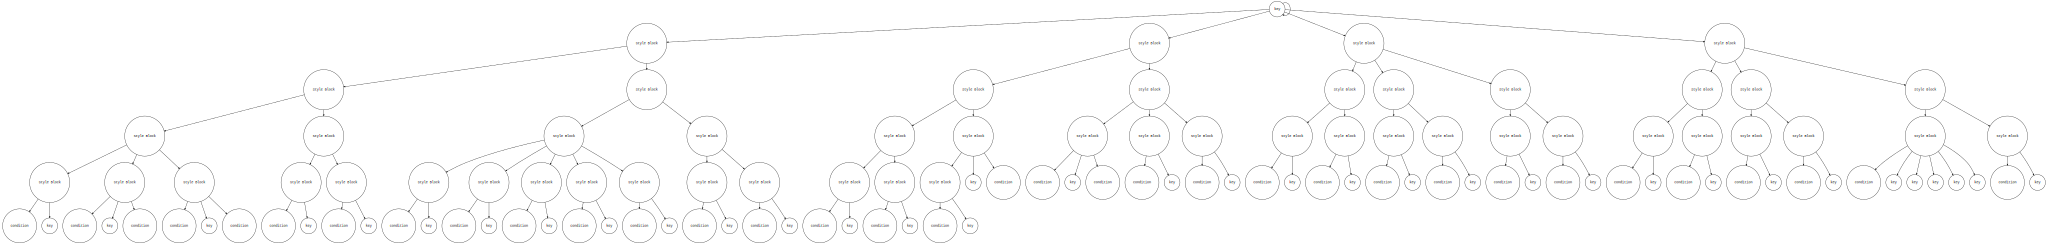

In [5]:
###############################################################################
#                                                                             #
#  AST TREE VISUALIZER                                                        #
#                                                                             #
###############################################################################


class NodeVisitor:
    def visit(self, node):
        method_name = 'visit_' + type(node).__name__
        visitor = getattr(self, method_name, self.generic_visit)
        return visitor(node)

    def generic_visit(self, node):
        raise Exception('No visit_{} method'.format(type(node).__name__))


class ASTVisualizer(NodeVisitor):
    def __init__(self, astTree):
        self.astTree = astTree
        self.ncount = 1
        self.nestedcount = 1
        self.dot_header = [textwrap.dedent("""\
        digraph astgraph {
          node [shape=circle, fontsize=12, fontname="Courier", height=.1];
          ranksep=.3;
          edge [arrowsize=.5]
        """)]
        self.dot_body = []
        self.dot_footer = ['}']

    def visit_list(self, node):
        for el in node:
            self.visit(el)
            
    def visit_QualifiedRule(self, node):
        
        s = '  node{} [label="Style Block"]\n'.format(self.nestedcount)
        self.dot_body.append(s)
        self.visit(node.prelude)
        self.visit(node.content)
        
        self.nestedcount += 1
        
        
    def visit_HashToken(self, node):
        #s = '  node{} [label="Hash"]\n'.format(self.ncount)
        #
        #self.dot_body.append(s)
        pass
    
    def visit_IdentToken(self, node):
        s ='  node{0} -> node{1}  node{1}[label="key"]\n'.format(self.nestedcount, self.ncount)
        self.dot_body.append(s)
        self.ncount += 1
    
    def visit_LiteralToken(self, node):
        #s = '  node{} [label="Literal"]\n'.format(self.ncount)
        #
        #self.dot_body.append(s)
        pass
    
    def visit_NumberToken(self, node):
        #s = '  node{} [label="value:Number"]\n'.format(self.ncount)
        #
        #self.dot_body.append(s)
        pass
    
    def visit_StringToken(self, node):
        #s = '  node{} [label="value:String"]\n'.format(self.ncount)
        #
        #self.dot_body.append(s)
        pass
    
    def visit_SquareBracketsBlock(self, node):
        s = '  node{} [label="condition"]\n'.format(self.ncount)
        self.visit(node.content)
        self.dot_body.append(s)
    
    def visit_WhitespaceToken(self, node):
        pass 

    def gendot(self):
        tree = self.astTree
        self.visit(tree)
        return ''.join(self.dot_header + self.dot_body + self.dot_footer)

test = tinycss2.parse_stylesheet(cartocss, skip_comments=True, skip_whitespace=True)

viz = ASTVisualizer(test)
content = viz.gendot()
Source(content)

In [47]:
# In the future we will generate our own tree from this but since there is a css parser for python for now lets use it.

def getStylesGroups(css: str):
    """
    Build tree for css styles
    """
    keys = re.findall('(?:[\s])*(?:#)([a-z-A-Z-0-9\--\_]+)(?:[\s])*(?=\{|\[)', css)
    values = re.split('(?:[\n|\s])*(?:[#])([a-z-A-Z-0-9\--\_]+)(?:[\s])*(?=\{|\[)', css)
    for i, styleG in enumerate(keys):
        if i == 0:
            n = values.index(styleG)
            del values[0:n+1]
        else:
            values.remove(styleG)
    
    return [keys, values]

def str2float(value: str):
    try:
        return float(value)
    except:
        return value

def str2bool(value: str):
    try:
        if value in ('true'):
            return True
        elif value in ('false'):
            return False
        else:
            raise
    except:
        return value

def dominantType(lst: list):
    try:
        counter=[]
        for el in css2vl.type_dict.keys():
            counter.append([el, sum(el in s.split('-')[0] for s in lst)])
        return sorted(counter, key=lambda x: x[1], reverse=True)
    except Exception as err:
        print(err)
        return None

def separateStyles(lst: list):
    if not lst:
        return 0
    count = [] 
    for el in lst:
        if not isinstance(el, list):
            myL ={}
            for x in el.strip().replace(' ','').split(';'):
                if x != '':
                    k, v = x.split(':')
                    myL.update({k : str2float(v)})                     
            count.append(myL)
        else:
            count.append(separateStyles(el)) 
    return count

def separateConditions(lst: list):
    if not lst:
        return 0
    count = [] 
    for el in lst:
        if not isinstance(el, list) and el != '':
            done = False
            for k,v in css2vl.cond_dict.items():
                if k in el and not done:
                    col, cond = el.replace(' ','').split(k)
                    count.append([v, col, str2float(cond.strip("'"))])
                    done = True
                    
        else:
            count.append(separateConditions(el)) 
    return count
    

def cartoToVectorStyles_v2(css):
    template = {
                'paint': {},
                'source-layer': 'layer0',
                'type': ''
                }
    #get group 
    r = getStylesGroups(css)
    #print(r)
    VLS = []
    for i, v in enumerate(r[1]):   
        # if there are styles with conditions we will cature them with between [}
        conditionText = re.findall('(?=\[)[\s\S]+?(?:\})', v)
        allStyles = re.findall('(?<=\{)[\s\S]+?(?=\})', v)
        #get the dominant type for this layer style
        typeS = dominantType(allStyles)
        print(typeS)
        #split conditions from its styles if they are outside {}
        conditions = [[x for x in re.findall('(?<=\[)[\s\S]+?(?=\]{|\]\n|\])', conds.strip(' ')) 
                       if any(a in x for a in css2vl.cond_dict.keys())]  for conds in conditionText]
        conditionStyles = [x for conds in conditionText 
                            for x in re.findall('(?<=\{)[\s\S]+?(?=\})', conds)]
        assert (len(conditions) == len(conditionStyles)),"conditions don't match nº styles: {0} {1}".format(len(conditions),len(conditionStyles))
        # we will capture the default styles of a group.
        defaultStyles = list(set(allStyles).difference(set(conditionStyles)))
        print(separateStyles(defaultStyles))
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%','default')
        template['type'] = css2vl.type_dict[typeS[0][0]]
        template['paint'] = {
                        css2vl.estStyleMatch[template['type']][k]: v
                        for k,v in separateStyles(defaultStyles)[0].items()
                        if k in css2vl.estStyleMatch[template['type']].keys()
                    }
        print(template)
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%','conditions styles')
        print(separateStyles(conditionStyles))
        print(len(separateStyles(conditionStyles)))
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%','conditions')
        print(separateConditions(conditions))
        print(len(separateConditions(conditions)))
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%','conditions')
        print(list(zip(separateConditions(conditions), separateStyles(conditionStyles))))
        break
        

        
    
cartoToVectorStyles_v2(cartocss)

[['marker', 17], ['polygon', 0], ['line', 0], ['point', 0], ['text', 0]]
[{'marker-line-width': 0.3, 'marker-line-color': '#FFF', 'marker-allow-overlap': 'true', 'marker-line-opacity': 0.0}]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% default
{'paint': {'circle-stroke-width': 0.3, 'circle-stroke-color': '#FFF', 'circle-stroke-opacity': 0.0}, 'source-layer': 'layer0', 'type': 'circle'}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% conditions styles
[{'marker-fill-opacity': 0.6}, {'marker-fill-opacity': 0.8}, {'marker-width': '12.0+8.0*[capacity_mw]/22500.0'}, {'marker-width': '4.0+8.0*[capacity_mw]/1500.0'}, {'marker-fill': '#000000'}, {'marker-fill': '#B15928'}, {'marker-fill': '#BC80BD'}, {'marker-fill': '#1F78B4'}, {'marker-fill': '#E31A1C'}, {'marker-fill': '#FF7F00'}, {'marker-fill': '#6A3D9A'}, {'marker-fill': '#5CA2D1'}, {'marker-fill': '#FDBF6F'}, {'marker-fill': '#229A00'}, {'marker-fill': '#B2DF8A'}, {'marker-width': 10.0}]
16
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% conditions
[[['<=', 'capac

In [6]:
###############################################################################
#                                                                             #
#  ERROR HANDELER                                                             #
#                                                                             #
###############################################################################

class ErrorCode(Enum):
    UNEXPECTED_TOKEN = 'Unexpected token'
    ID_NOT_FOUND     = 'Identifier not found'
    DUPLICATE_ID     = 'Duplicate id found'


class Error(Exception):
    def __init__(self, error_code=None, token=None, message=None):
        self.error_code = error_code
        self.token = token
        # add exception class name before the message
        self.message = f'{self.__class__.__name__}: {message}'


class LexerError(Error):
    pass


class ParserError(Error):
    pass


class SemanticError(Error):
    pass

###############################################################################
#                                                                             #
#  INTERPRETER                                                                #
#                                                                             #
###############################################################################
class ARType(Enum):
    STYLEBLOCK  = 'STYLEBLOCK'
    CONDITION = 'CONDITION'
    STYLEC  = 'STYLEC'

class NodeVisitor:
    def visit(self, node):
        method_name = 'visit_' + type(node).__name__
        #print(colored(method_name, 'red') if method_name == 'visit_QualifiedRule' else colored(' '+method_name, 'green'))
        visitor = getattr(self, method_name, self.generic_visit)
        return visitor(node)

    def generic_visit(self, node):
        raise Exception('No visit_{} method'.format(type(node).__name__))


class CallStack:
    def __init__(self):
        self._records = []

    def push(self, ar):
        self._records.append(ar)

    def pop(self):
        return self._records.pop()

    def peek(self):
        return self._records[-1]

    def __str__(self):
        s = '\n'.join(repr(ar) for ar in reversed(self._records))
        s = colored(f'CALL STACK\n{s}\n\n', 'red')
        return s

    def __repr__(self):
        return self.__str__()


class ActivationRecord:
    def __init__(self, name, type, nesting_level):
        self.name = name
        self.type = type
        self.nesting_level = nesting_level
        self.members = {}

    def __setitem__(self, key, value):
        self.members[key] = value

    def __getitem__(self, key):
        return self.members[key]

    def get(self, key):
        return self.members.get(key)

    def __str__(self):
        lines = [
            '{level}: {type} {name}'.format(
                level=self.nesting_level,
                type=self.type.value,
                name=self.name,
            )
        ]
        for name, val in self.members.items():
            lines.append(f'   {name:<20}: {val}')

        s = '\n'.join(lines)
        return s

    def __repr__(self):
        return self.__str__()


class Interpreter(NodeVisitor):
    def __init__(self, tree):
        self.tree = tree
        self.call_stack = CallStack()

    def log(self, msg):
        #if _SHOULD_LOG_STACK:
         #   print(msg)
        print(msg)
    def error(self, error_code, token):
        raise ParserError(
            error_code=error_code,
            token=token,
            message=f'{error_code.value} -> {token}',
        )

    def visit_list(self, node):
        for el in node:
            self.visit(el)
            
    def visit_QualifiedRule(self, node):
        rootBlock = [el for el in node.prelude if type(el).__name__ == 'HashToken']
        if len(rootBlock) == 1:
            template = {
                'paint': {},
                'source-layer': 'layer0',
                'type': '',
                "minzoom": 3,
                "maxzoom": 12,
                }
            
            program_name = rootBlock[0].value
            self.log(f'ENTER: Style block {program_name}')
            self.log(colored('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%','blue'))
            ar = ActivationRecord(
                    name=program_name,
                    type=ARType.STYLEBLOCK,
                    nesting_level=1,
            )
            self.call_stack.push(ar)
            self.log(str(self.call_stack))
            node.prelude.remove(rootBlock[0])
            self.visit(node.prelude)
            
        elif len(rootBlock) == 0:
            self.visit(node.prelude)
        else:
            self.error(
                error_code=ErrorCode.UNEXPECTED_TOKEN,
                token=f'too many #: {rootBlock}',
            )
        self.log(f'ENTER: Style block content')
        #style = {}
        testStyle = {
            'key':[],
            'value':[],
            'function':[]
        }
        try:
            for el in node.content:
                r = self.visit(el)
                if type(r) == tuple:
                    if r[0] =='key' and (type(str2bool(r[1])) == bool):
                        testStyle['value'].append(r[1])
                        testStyle['function'].append(None)
                    elif r[0] =='key':
                        testStyle['key'].append(r[1])      
                    else:
                        testStyle[r[0]].append(r[1])
                        testStyle['function'].append(None)
            assert len(testStyle['key']) == len(testStyle['value']) == len(testStyle['function']), f"style not valid: {testStyle}" 
            ar2 = ActivationRecord(
                        name='test',
                        type=ARType.STYLEC,
                        nesting_level=3,
                )     
            self.call_stack.push(ar2)
        except Exception as err:
            pass
        print(testStyle)   
        #self.log(f'LEAVE: Style block {program_name}')
        self.log(str(self.call_stack))

        #self.call_stack.pop()
        
        
    def visit_HashToken(self, node):
        print('     ',colored('#'+node.value, 'yellow'))
        return 'value', '#'+node.value
    
    def visit_IdentToken(self, node):
        print('     ',colored(node.value, 'yellow'))
        return 'key', node.value
    
    def visit_LiteralToken(self, node):
        if node.value in css2vl.cond_dict.keys():
            print('     ',colored(node.value, 'yellow'))
            return 'cond', node.value
        
    
    def visit_NumberToken(self, node):
        print('     ',colored(node.value, 'yellow'))
        return 'value', node.value
    
    def visit_StringToken(self, node):
        print('     ',colored(node.value, 'yellow'))
        return 'value', node.value
    
    def visit_SquareBracketsBlock(self, node):    
        ar = ActivationRecord(
                    name='test',
                    type=ARType.CONDITION,
                    nesting_level=2,
            )
        self.call_stack.push(ar)
        self.log(f'ENTER: condition block')
        self.log(colored('------','blue'))
        self.visit(node.content)
        self.log(colored('______','blue'))
    
    def visit_WhitespaceToken(self, node):
        pass 

    def interpret(self):
        tree = self.tree
        if tree is None:
            return ''
        return self.visit(tree)
test = tinycss2.parse_stylesheet(cartocss, skip_comments=True, skip_whitespace=True)
interpreter = Interpreter(test)
interpreter.interpret()


ENTER: Style block powerwatch_data_20180102
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
CALL STACK
1: STYLEBLOCK powerwatch_data_20180102


ENTER: Style block content
      marker-line-width
{'key': [], 'value': [], 'function': []}
CALL STACK
1: STYLEBLOCK powerwatch_data_20180102


ENTER: condition block
------
      capacity_mw
      <
      =
      1500.0
______
ENTER: Style block content
      marker-fill-opacity
{'key': [], 'value': [], 'function': []}
CALL STACK
2: CONDITION test
1: STYLEBLOCK powerwatch_data_20180102


ENTER: condition block
------
      capacity_mw
      >
      1500.0
______
ENTER: Style block content
      marker-fill-opacity
{'key': [], 'value': [], 'function': []}
CALL STACK
2: CONDITION test
2: CONDITION test
1: STYLEBLOCK powerwatch_data_20180102


ENTER: condition block
------
      capacity_mw
      >
      1500.0
______
ENTER: Style block content
      marker-width
{'key': [], 'value': [], 'function': []}
CALL STACK
2: CONDITION test

In [7]:
tinycss2.serialize(test)

'#powerwatch_data_20180102 { marker-line-width:0.3; marker-line-color:#FFF; marker-allow-overlap: true; marker-line-opacity:0;}[capacity_mw <= 1500] {marker-fill-opacity: 0.6;}[capacity_mw > 1500] {marker-fill-opacity: 0.8;}[capacity_mw > 1500]{marker-width: 12.0/**/+8.0*[capacity_mw]/22500.0;}[capacity_mw <= 1500]{marker-width: 4.0/**/+8.0*[capacity_mw]/1500.0;}[primary_fuel="Coal"]{marker-fill:#000000;}[primary_fuel="Oil"]{marker-fill:#B15928;}[primary_fuel="Gas"]{marker-fill:#BC80BD;}[primary_fuel="Hydro"][primary_fuel="Hydro"]{marker-fill:#1F78B4;}[primary_fuel="Nuclear"]{marker-fill:#E31A1C;}[primary_fuel="Solar"]{marker-fill:#FF7F00;}[primary_fuel="Waste"]{marker-fill:#6A3D9A;}[primary_fuel="Wind"]{marker-fill:#5CA2D1;}[primary_fuel="Geothermal"]{marker-fill:#FDBF6F;}[primary_fuel="Biomass"]{marker-fill:#229A00;}[primary_fuel="Others"][primary_fuel="Others"]{marker-fill:#B2DF8A;}[capacity_mw>=9000]{marker-width:10;}#powerwatch_data_20180102 { marker-line-width:0.3; marker-line-co

# validator

In [17]:
VLStylesExample =json.loads(""" [
{
"paint": {
"circle-stroke-width": 0.3,
"circle-stroke-color": "#FFF",
"circle-stroke-opacity": 0
},
"source-layer": "layer0",
"type": "line",
"filter": [
"all"
]
},
{
"paint": {
"circle-stroke-width": 0.3,
"circle-stroke-color": "#FFF",
"circle-stroke-opacity": 0
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all"
]
},
{
"paint": {
"circle-opacity": 0.6
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
"<=",
"capacity_mw ",
1500
]
]
},
{
"paint": {
"circle-opacity": 0.8
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
">",
"capacity_mw ",
1500
]
]
},
{
"paint": {
"circle-radius": " 12.0+8.0*[capacity_mw]/22500.0"
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
">",
"capacity_mw ",
1500
]
]
},
{
"paint": {
"circle-radius": " 4.0+8.0*[capacity_mw]/1500.0"
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
"<=",
"capacity_mw ",
1500
]
]
},
{
"paint": {
"circle-color": "#000000"
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
"==",
"primary_fuel",
"Coal"
]
]
},
{
"paint": {
"circle-color": "#B15928"
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
"==",
"primary_fuel",
"Oil"
]
]
},
{
"paint": {
"circle-color": "#BC80BD"
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
"==",
"primary_fuel",
"Gas"
]
]
},
{
"paint": {
"circle-color": "#1F78B4"
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
"==",
"primary_fuel",
"Hydro"
]
]
},
{
"paint": {
"circle-color": "#E31A1C"
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
"==",
"primary_fuel",
"Nuclear"
]
]
},
{
"paint": {
"circle-color": "#FF7F00"
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
"==",
"primary_fuel",
"Solar"
]
]
},
{
"paint": {
"circle-color": "#6A3D9A"
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
"==",
"primary_fuel",
"Waste"
]
]
},
{
"paint": {
"circle-color": "#5CA2D1"
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
"==",
"primary_fuel",
"Wind"
]
]
},
{
"paint": {
"circle-color": "#FDBF6F"
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
"==",
"primary_fuel",
"Geothermal"
]
]
},
{
"paint": {
"circle-color": "#229A00"
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
"==",
"primary_fuel",
"Biomass"
]
]
},
{
"paint": {
"circle-color": "#B2DF8A"
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
"==",
"primary_fuel",
"Others"
]
]
},
{
"paint": {
"circle-radius": 10
},
"source-layer": "layer0",
"type": "circle",
"filter": [
"all",
[
">=",
"capacity_mw",
9000
]
]
}
]
""")

In [18]:
VLStylesExample =json.loads("""
[{
"source-layer": "layer0",
"type": "symbol",
"layout": {
"icon-image": "circle-15",
"icon-allow-overlap": true,
"text-field": "circle",
"text-font": [
"Open Sans Bold",
"Arial Unicode MS Bold"
],
"text-size": 11,
"text-transform": "uppercase",
"text-letter-spacing": 0.05,
"text-offset": [0, 1.5]
},
"paint": {
"text-color": "#202",
"text-halo-color": "#fff",
"text-halo-width": 2
},
"filter": ["==", "icon", "circle"]
}]
""")

In [19]:
def testVLS(layerid, VLStyles):
    for i, style in enumerate(VLStyles):
        if type(style) != dict:
            pass
        else:
            style.update({'id': f'test_{i}',
                  'source':"carto-layer"})


    template = {
        "version": 8,
        "name": "Mapbox Streets",
        "sprite": "mapbox://sprites/mapbox/streets-v8",
        "glyphs": "mapbox://fonts/mapbox/{fontstack}/{range}.pbf",
        "sources": {
            "carto-layer": {
        "type": "vector",
        "tiles": [
            "http://a.example.com/tiles/{z}/{x}/{y}.pbf",
            "http://b.example.com/tiles/{z}/{x}/{y}.pbf"
        ],
        "maxzoom": 14
    }
    },
        "layers": VLStyles
    }
    fileName = f'{layerid}-styles.json'
    with open(fileName, 'w') as outfile:
        json.dump(template, outfile)
        
        #outfile.write(VLStylesExample)
    try:
        out = subprocess.Popen(shlex.split(f"gl-style-validate {fileName} --json"), 
                   stdout=subprocess.PIPE, 
                   stderr=subprocess.STDOUT,
                   universal_newlines=True)
        
        stdout,stderr = out.communicate()
        if not stderr:
            if stdout is not '':
                return 409, json.loads(stdout)
            else:
                return 200, []
        else:
            return 500, [{"error":stderr}]
    except Exception as e:
        pass
    finally:
        os.remove(fileName)
        

In [20]:
import LMIPy as lmi
from LMIPy import utils
from pprint import pprint
from tqdm import tqdm
from multiprocessing import Pool

In [21]:
myLayerColl = lmi.Collection(object_type=['layer'], app=['rw'], limit=10000, server='https://api.resourcewatch.org',)

In [22]:
print('Total:', len(myLayerColl))
testnC = list(filter(lambda layer: layer['attributes'].get('provider','') == 'cartodb', myLayerColl))
print('carto: ',len(testnC))
testnf = list(filter(lambda layer: layer['attributes'].get('provider','') == 'featureservice', myLayerColl))
print('featureservice: ',len(testnf))
testnw = list(filter(lambda layer: layer['attributes'].get('provider','') == 'wms', myLayerColl))
print('wms: ',len(testnw))
testng = list(filter(lambda layer: layer['attributes'].get('provider','') == 'gee', myLayerColl))
print('gee: ',len(testng))
testnL = list(filter(lambda layer: layer['attributes'].get('provider','') == 'leaflet', myLayerColl))
print('leaflet: ',len(testnL))

Total: 2323
carto:  1548
featureservice:  3
wms:  10
gee:  654
leaflet:  107


In [23]:
def f(cartoLayer):
    styles = cartoLayer['attributes']['layerConfig']['body'].get('vectorLayers',None)
    layerId = cartoLayer['id']
    layerType = cartoLayer['attributes']['layerConfig'].get('layerType',None)
    if styles:
        status, message = testVLS(layerId, styles)
        if status!=200:
            print(layerId,': ',status)
        return {'id': layerId,
                'status': status,
                'message': message,
                'layerType':layerType}
            
    else:
        print(layerId,': 404')
        return {'id': layerId,
                'status': 404,
                'message': [{'message':'vectorLayers not found in layer spec'}],
               'layerType':layerType
               }
    
result = []
with Pool(processes=6) as p:
        result = p.map(f, testnC)

89f6de8a-3560-40c2-b6a4-1b5acefeb3a5 :  409
eacf9f96-228d-4492-8998-ec1d873927aa :  409
71439f17-7757-4115-a668-0fc3f5822091 : 404
982ade70-4e95-4fb1-98c6-036ec9a53463 : 404
02d0854d-ea31-4457-8409-8d5d7ba64337 : 404
bbcca0ae-a6c4-49f0-ad45-8e07490bb935 : 404
11e2e555-1afa-4459-8a42-412f12f3eae5 : 404
481c1e5e-49cb-4e8f-9e92-7f915f94bf54 : 404
31bca780-a9e0-411f-bb08-61508e7d78bb : 404
ad8ba2b5-c92a-4516-9b55-31534db0db25 :  409
4fb6d587-e817-4408-aa00-ef4360770782 : 404
71a6b09e-3593-4805-8801-22033e16a60a : 404
96e2298c-d962-402d-bf62-0483908f767a : 404
ca6a582f-e945-4f0b-ab74-02fff721cd50 : 404
47134cd9-9523-413e-a855-a0953ea86e0f : 404
8cb5aab2-a40d-4e50-a9a7-8b9884ac585c : 404
1aa25319-31ee-422a-bfcc-a31514e826a9 : 404
67862765-88e9-490b-a48e-21563c3ad803 : 404
c94cc91a-1d17-4f66-97be-97f59e1c5320 : 404
7813bb63-edf5-4f82-9d23-9ea4d1d4335a : 404
dfeaa37f-8f0d-4f05-917c-622c438bf338 : 404
746d9a14-e615-4f14-8f00-4bf17d15f76b : 404
4b202c6b-5bd1-469e-a7a6-c7d35da03a1f : 404
f84b94e2

c98dc599-cce9-403d-bd54-de10bc63e55d :  409
714acb82-7464-4077-a289-2c2164c25e19 :  409
4143c335-b6f1-4a90-9561-f7fea00e3dda :  409
2bbf8eba-3588-49f4-9736-c2e269755404 :  409
23c8f4bf-0039-4eee-8064-6b6a4a858a8c :  409
4f4d4e68-f8bb-4d76-8f16-f933ce7ed9de :  409
5e0af75a-b699-4fcc-9eb8-fe6e38395263 :  409
4cf6fdb9-ca14-469a-ab2e-075b10dc04c8 : 404
d0a1ae43-6a14-443b-86d6-d01dfac842fa :  409
ff245eb6-6678-4366-aca9-c3a661cf85fb :  409
bee6d2ab-581a-4fbb-933a-19df246818af :  409
3c6afe74-d11c-4bd9-8a38-b1b8fc16e4d5 :  409
ea84850e-628a-4db9-8430-6f0c3cdea422 :  409
afca368a-deb3-4abb-ad87-1c31f53c8a2a :  409
ca4dff66-4210-4e96-91d0-b7f2e9a9223d :  409
5f6d13fb-7a36-4fea-8a07-1e660f627333 :  409
c97ce1ea-8e76-46aa-95cc-1fa8dc412225 :  409
f8388cf7-a14d-4148-b2c5-eab713f9c5d9 :  409
725edd3c-bba4-479c-894f-50c0b9b6cf96 :  409
9eafd143-018d-4fc8-bc6c-e304f66d4460 :  409
b17e902f-79ed-42fd-b366-fb5ed7e36dca :  409
90878652-7934-4d7d-a412-021056c26707 : 404
4747617d-0627-416f-83f5-6cde134a54

In [24]:
IssuesList = list(filter(lambda status: status.get('status','') != 200, result))
len(IssuesList)

363

In [25]:
toSolve=list(filter(lambda status: status.get('layerType','') != 'raster', IssuesList))
len(toSolve)

193

In [28]:
for x in toSolve:
    print(x)

{'id': '89f6de8a-3560-40c2-b6a4-1b5acefeb3a5', 'status': 409, 'message': [{'message': 'layers[0].paint.circle-stroke-width: unknown property "circle-stroke-width"', 'line': 1}, {'message': 'layers[0].paint.circle-stroke-color: unknown property "circle-stroke-color"', 'line': 1}, {'message': 'layers[0].paint.circle-stroke-opacity: unknown property "circle-stroke-opacity"', 'line': 1}], 'layerType': 'vector'}
{'id': 'eacf9f96-228d-4492-8998-ec1d873927aa', 'status': 409, 'message': [{'message': 'layers[0].paint.circle-stroke-width: unknown property "circle-stroke-width"', 'line': 1}, {'message': 'layers[0].paint.circle-stroke-color: unknown property "circle-stroke-color"', 'line': 1}, {'message': 'layers[0].paint.circle-stroke-opacity: unknown property "circle-stroke-opacity"', 'line': 1}], 'layerType': 'vector'}
{'id': 'ad8ba2b5-c92a-4516-9b55-31534db0db25', 'status': 409, 'message': [{'message': 'layers[0].paint.circle-stroke-color: unknown property "circle-stroke-color"', 'line': 1}, {

In [ ]:
testnC